# Iteration 5: Model selection

## Load data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('./data/housing_iteration_3_classification.csv')
df.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
3,9550,60.0,756,3,1,0,3,0,0,0,RL,Norm,GasA,Pave,Y,BrkTil
4,14260,84.0,1145,4,1,0,3,192,0,0,RL,Norm,GasA,Pave,Y,PConc


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotArea       1460 non-null   int64  
 1   LotFrontage   1201 non-null   float64
 2   TotalBsmtSF   1460 non-null   int64  
 3   BedroomAbvGr  1460 non-null   int64  
 4   Fireplaces    1460 non-null   int64  
 5   PoolArea      1460 non-null   int64  
 6   GarageCars    1460 non-null   int64  
 7   WoodDeckSF    1460 non-null   int64  
 8   ScreenPorch   1460 non-null   int64  
 9   Expensive     1460 non-null   int64  
 10  MSZoning      1460 non-null   object 
 11  Condition1    1460 non-null   object 
 12  Heating       1460 non-null   object 
 13  Street        1460 non-null   object 
 14  CentralAir    1460 non-null   object 
 15  Foundation    1460 non-null   object 
dtypes: float64(1), int64(9), object(6)
memory usage: 182.6+ KB


In [4]:
for col in df.select_dtypes(exclude="number").columns:
    #print(df[col].value_counts())
    pass

In [5]:
y = df.pop('Expensive')

In [6]:
X = df.copy()

## Train-test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build Pipeline

### Define preprocessing steps

In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [9]:
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").columns
X_num_columns = X.select_dtypes(include="number").columns

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer()), 
           ('num_scaler', MinMaxScaler())
          ])

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='N_A')), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'#,infrequent_if_exist', 
                                         #min_frequency=0.03
                                        ))
          ])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ])

### Define classifiers to test

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [12]:
classifiers = [
    ('DecisionTree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('LogReg', LogisticRegression()),
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC())
]

### Create a pipeline for each classifier

In [13]:
pipelines = []
for name, clf in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', clf)]).set_output(transform='pandas')
    pipelines.append((name, pipe))


## Exploratory hyperparameter search

### Define exploratory hyperparameters

In [15]:
param_grids_explore = {
    'DecisionTree': {
        'classifier__max_depth': range(2, 14),
        'classifier__min_samples_leaf': range(3, 15, 2),
        'classifier__min_samples_split': range(3, 30, 5),
        'classifier__criterion':['gini', 'entropy']
    },
    'KNN': {
        'classifier__n_neighbors': range(3, 33, 5),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['minkowski', 'manhattan'],
    },
    'LogReg': {
        'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
        'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
    },
    'RandomForest': {
        'classifier__n_estimators': range(5, 100, 10),
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_leaf': range(1, 20, 2)
    },
    'GradientBoosting': {
        'classifier__n_estimators': range(1, 300, 20),
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
    },
    'SVM': {
        'classifier__C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100],
        'classifier__gamma': ['scale', 'auto']
    }
}


### Fit and evaluate models

In [16]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Fit and evaluate each pipeline
scores_explore = {}
params_explore = {}

for name, pipe in pipelines:
    print(f"\nTraining and evaluating {name}...")
    grid_search = GridSearchCV(pipe, 
                               param_grids_explore[name], 
                               cv=5, scoring='accuracy',
                              verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Evaluate on test set
    #y_pred = grid_search.predict(X_test)
    #accuracy = accuracy_score(y_test, y_pred)
    
    #print("Best parameters found:")
    #print(grid_search.best_params_)
    #print("Classification report:")
    #print(classification_report(y_test, y_pred))
    #print(f"Accuracy: {accuracy:.4f}")
    
    scores_explore[name] = grid_search.best_score_
    params_explore[name] = grid_search.best_params_


Training and evaluating DecisionTree...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:
{'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 9, 'classifier__min_samples_split': 3}

Training and evaluating KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 13, 'classifier__weights': 'distance'}

Training and evaluating LogReg...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:
{'classifier__C': 0.01, 'classifier__penalty': None}

Training and evaluating RandomForest...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters found:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 45}

Training and evaluating GradientBoosting...
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best parameter

In [18]:
scores_explore

{'DecisionTree': 0.9212354645831041,
 'KNN': 0.9255089688566084,
 'LogReg': 0.9280804079087341,
 'RandomForest': 0.9366310846997543,
 'GradientBoosting': 0.9331976083049044,
 'SVM': 0.9212317963390925}

In [19]:
params_explore

{'DecisionTree': {'classifier__criterion': 'gini',
  'classifier__max_depth': 5,
  'classifier__min_samples_leaf': 9,
  'classifier__min_samples_split': 3},
 'KNN': {'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 13,
  'classifier__weights': 'distance'},
 'LogReg': {'classifier__C': 0.01, 'classifier__penalty': None},
 'RandomForest': {'classifier__max_depth': 20,
  'classifier__min_samples_leaf': 1,
  'classifier__n_estimators': 45},
 'GradientBoosting': {'classifier__learning_rate': 0.1,
  'classifier__n_estimators': 181},
 'SVM': {'classifier__C': 10, 'classifier__gamma': 'scale'}}

In [20]:
#TODO: fine-tune parameters

## Refined hyperparameter search

### Define exploratory hyperparameters

In [20]:
param_grids_refined = {
    'DecisionTree': {
        'classifier__max_depth': range(3, 7),
        'classifier__min_samples_leaf': range(7, 12),
        'classifier__min_samples_split': range(11, 16),
        'classifier__criterion':['gini', 'entropy']
    },
    'KNN': {
        'classifier__n_neighbors': range(3, 33, 5),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['minkowski', 'manhattan'],
    },
    #'RandomForest': {
    #    'classifier__n_estimators': [50, 100, 200],
    #    'classifier__max_depth': [None, 10, 20]
    #},
    #'GradientBoosting': {
    #    'classifier__n_estimators': [50, 100, 200],
    #    'classifier__learning_rate': [0.1, 0.05, 0.01]
    #},
    #'SVM': {
    #    'classifier__C': [0.1, 1, 10],
    #    'classifier__gamma': ['scale', 'auto']
    #}
}


### Fit and evaluate models

In [21]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [27]:
# Fit and evaluate each pipeline
scores_refined = {}
params_refined = {}
accuracy_train = {}
estimators = {}

for name, pipe in pipelines:
    print(f"\nTraining and evaluating {name}...")
    grid_search = GridSearchCV(pipe, 
                               param_grids_refined[name], 
                               cv=5, scoring='accuracy',
                              verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Evaluate on test set
    y_train_pred = grid_search.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred)
    
    print("Best parameters found:")
    print(grid_search.best_params_)
    #print("Classification report:")
    #print(classification_report(y_test, y_pred))
    print(f"Accuracy for training data: {acc_train:.4f}")
    
    scores_refined[name] = grid_search.best_score_
    params_refined[name] = grid_search.best_params_
    estimators[name] = grid_search.best_estimator_
    accuracy_train[name] = acc_train


Training and evaluating DecisionTree...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters found:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 7, 'classifier__min_samples_split': 11}
Accuracy for training data: 0.9272

Training and evaluating KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:
{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 23, 'classifier__weights': 'uniform'}
Accuracy for training data: 0.9170


In [28]:
scores_refined

{'DecisionTree': 0.9084296247386376, 'KNN': 0.9169766332856462}

In [29]:
params_refined

{'DecisionTree': {'classifier__criterion': 'entropy',
  'classifier__max_depth': 5,
  'classifier__min_samples_leaf': 7,
  'classifier__min_samples_split': 11},
 'KNN': {'classifier__metric': 'manhattan',
  'classifier__n_neighbors': 23,
  'classifier__weights': 'uniform'}}

In [30]:
accuracy_train

{'DecisionTree': 0.9272260273972602, 'KNN': 0.9169520547945206}

## Check performance on test data

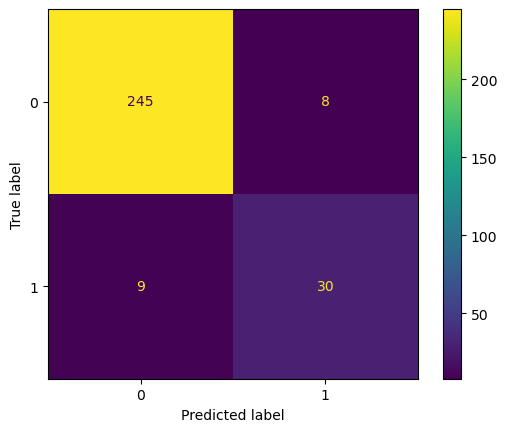

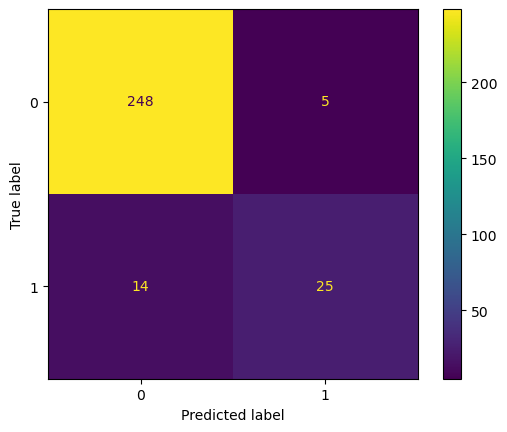

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay
accuracy_test = {}

for name in estimators:
    accuracy_test[name] = estimators[name].score(X_test, y_test)
    
    ConfusionMatrixDisplay.from_estimator(estimators[name],
                                      X_test,
                                      y_test,
                                      );

In [44]:
accuracy_test

{'DecisionTree': 0.9417808219178082, 'KNN': 0.934931506849315}

In [27]:
best_estimator.score(X_test, y_test)

0.9315068493150684